In [1]:
import pandas as pd
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Path configuration (raw string for Windows paths)
AUDIO_DIR = r"C:\Users\diogo\OneDrive\Ambiente de Trabalho\ESC-50-master\audio"
METADATA_PATH = r"C:\Users\diogo\OneDrive\Ambiente de Trabalho\ESC-50-master\meta\esc50.csv"

# Load metadata
metadata = pd.read_csv(METADATA_PATH)

# Improved feature extraction with error handling
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=22050, duration=5)  # Standardize to 5s clips
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512)
        return np.mean(mfccs.T, axis=0) #check if this is the right way to average
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Extract features for all files
features = []
valid_indices = []

for idx, row in metadata.iterrows():
    file_path = os.path.join(AUDIO_DIR, row['filename'])
    if not os.path.exists(file_path):
        print(f"Missing file: {file_path}")
        continue
        
    feature = extract_features(file_path)
    if feature is not None:
        features.append(feature)
        valid_indices.append(idx)

    # Progress tracking
    if idx % 100 == 0:
        print(f"Processed {idx+1}/{len(metadata)} files")

# Filter metadata and create feature matrix
valid_metadata = metadata.iloc[valid_indices]
X = np.array(features)
y = valid_metadata['target'].values

# Train-test split (stratified by category)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Optimized KNN model
knn = KNeighborsClassifier(
    n_neighbors=15,  # Start with larger k for 50 classes
    weights='distance',
    metric='cosine',  # Often better for audio features
    n_jobs=-1
)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"\nModel Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Class distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True))

Processed 1/2000 files
Processed 101/2000 files
Processed 201/2000 files
Processed 301/2000 files
Processed 401/2000 files
Processed 501/2000 files
Processed 601/2000 files
Processed 701/2000 files
Processed 801/2000 files
Processed 901/2000 files
Processed 1001/2000 files
Processed 1101/2000 files
Processed 1201/2000 files
Processed 1301/2000 files
Processed 1401/2000 files
Processed 1501/2000 files
Processed 1601/2000 files
Processed 1701/2000 files
Processed 1801/2000 files
Processed 1901/2000 files

Model Accuracy: 0.42
Class distribution in test set:
11    0.02
38    0.02
19    0.02
39    0.02
40    0.02
14    0.02
10    0.02
4     0.02
27    0.02
48    0.02
23    0.02
31    0.02
29    0.02
8     0.02
41    0.02
42    0.02
1     0.02
20    0.02
30    0.02
12    0.02
22    0.02
2     0.02
9     0.02
49    0.02
7     0.02
21    0.02
32    0.02
5     0.02
24    0.02
25    0.02
16    0.02
45    0.02
18    0.02
34    0.02
36    0.02
33    0.02
46    0.02
15    0.02
37    0.02
43    0.0

In [2]:
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=22050, duration=5)
    
    # MFCCs with deltas
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # Additional features
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    
    # Aggregate statistics
    features = np.concatenate([
        np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
        np.mean(delta_mfccs, axis=1), np.mean(delta2_mfccs, axis=1),
        np.mean(spectral_contrast, axis=1), np.mean(chroma, axis=1)
    ])
    
    return features

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_neighbors': randint(10, 50),  # Correct syntax
    'weights': ['uniform', 'distance'],  # Comma instead of semicolon
    'metric': ['cosine', 'euclidean', 'manhattan']  # Correct metric names
}

search = RandomizedSearchCV(
    KNeighborsClassifier(),  # Correct class name
    param_distributions=param_dist,  # Correct parameter name
    n_iter=50,  # Correct parameter name
    cv=3,
    n_jobs=-1,  # Correct parameter name
    random_state=42  # Correct parameter name
)
search.fit(X_train, y_train)  # Correct method name

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'metric': ['cosine', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017275E194F0>,
                                        'weights': ['uniform', 'distance']},
                   random_state=42)

In [4]:
# Replace the existing cross_val_score code with:
from sklearn.model_selection import PredefinedSplit

# Create official ESC-50 folds
fold_indices = []
for fold in range(1, 6):
    train_idx = metadata[metadata['fold'] != fold].index
    test_idx = metadata[metadata['fold'] == fold].index
    fold_indices.append((train_idx, test_idx))

# Use best model from hyperparameter tuning
best_knn = search.best_estimator_
scores = cross_val_score(best_knn, X, y, cv=fold_indices, n_jobs=-1)
print(f"ESC-50 Cross-Validation Accuracy: {np.mean(scores):.2f} ± {np.std(scores):.2f}")

NameError: name 'cross_val_score' is not defined

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    'KNN': best_knn,
    'RandomForest': RandomForestClassifier(n_estimators=200, class_weight='balanced'),
    'SVM': SVC(kernel='rbf', class_weight='balanced')
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=fold_indices, n_jobs=-1)
    print(f"{name}: {np.mean(scores):.2f} ± {np.std(scores):.2f}")

KNN: 0.22 ± 0.02
RandomForest: 0.30 ± 0.03
SVM: 0.20 ± 0.03


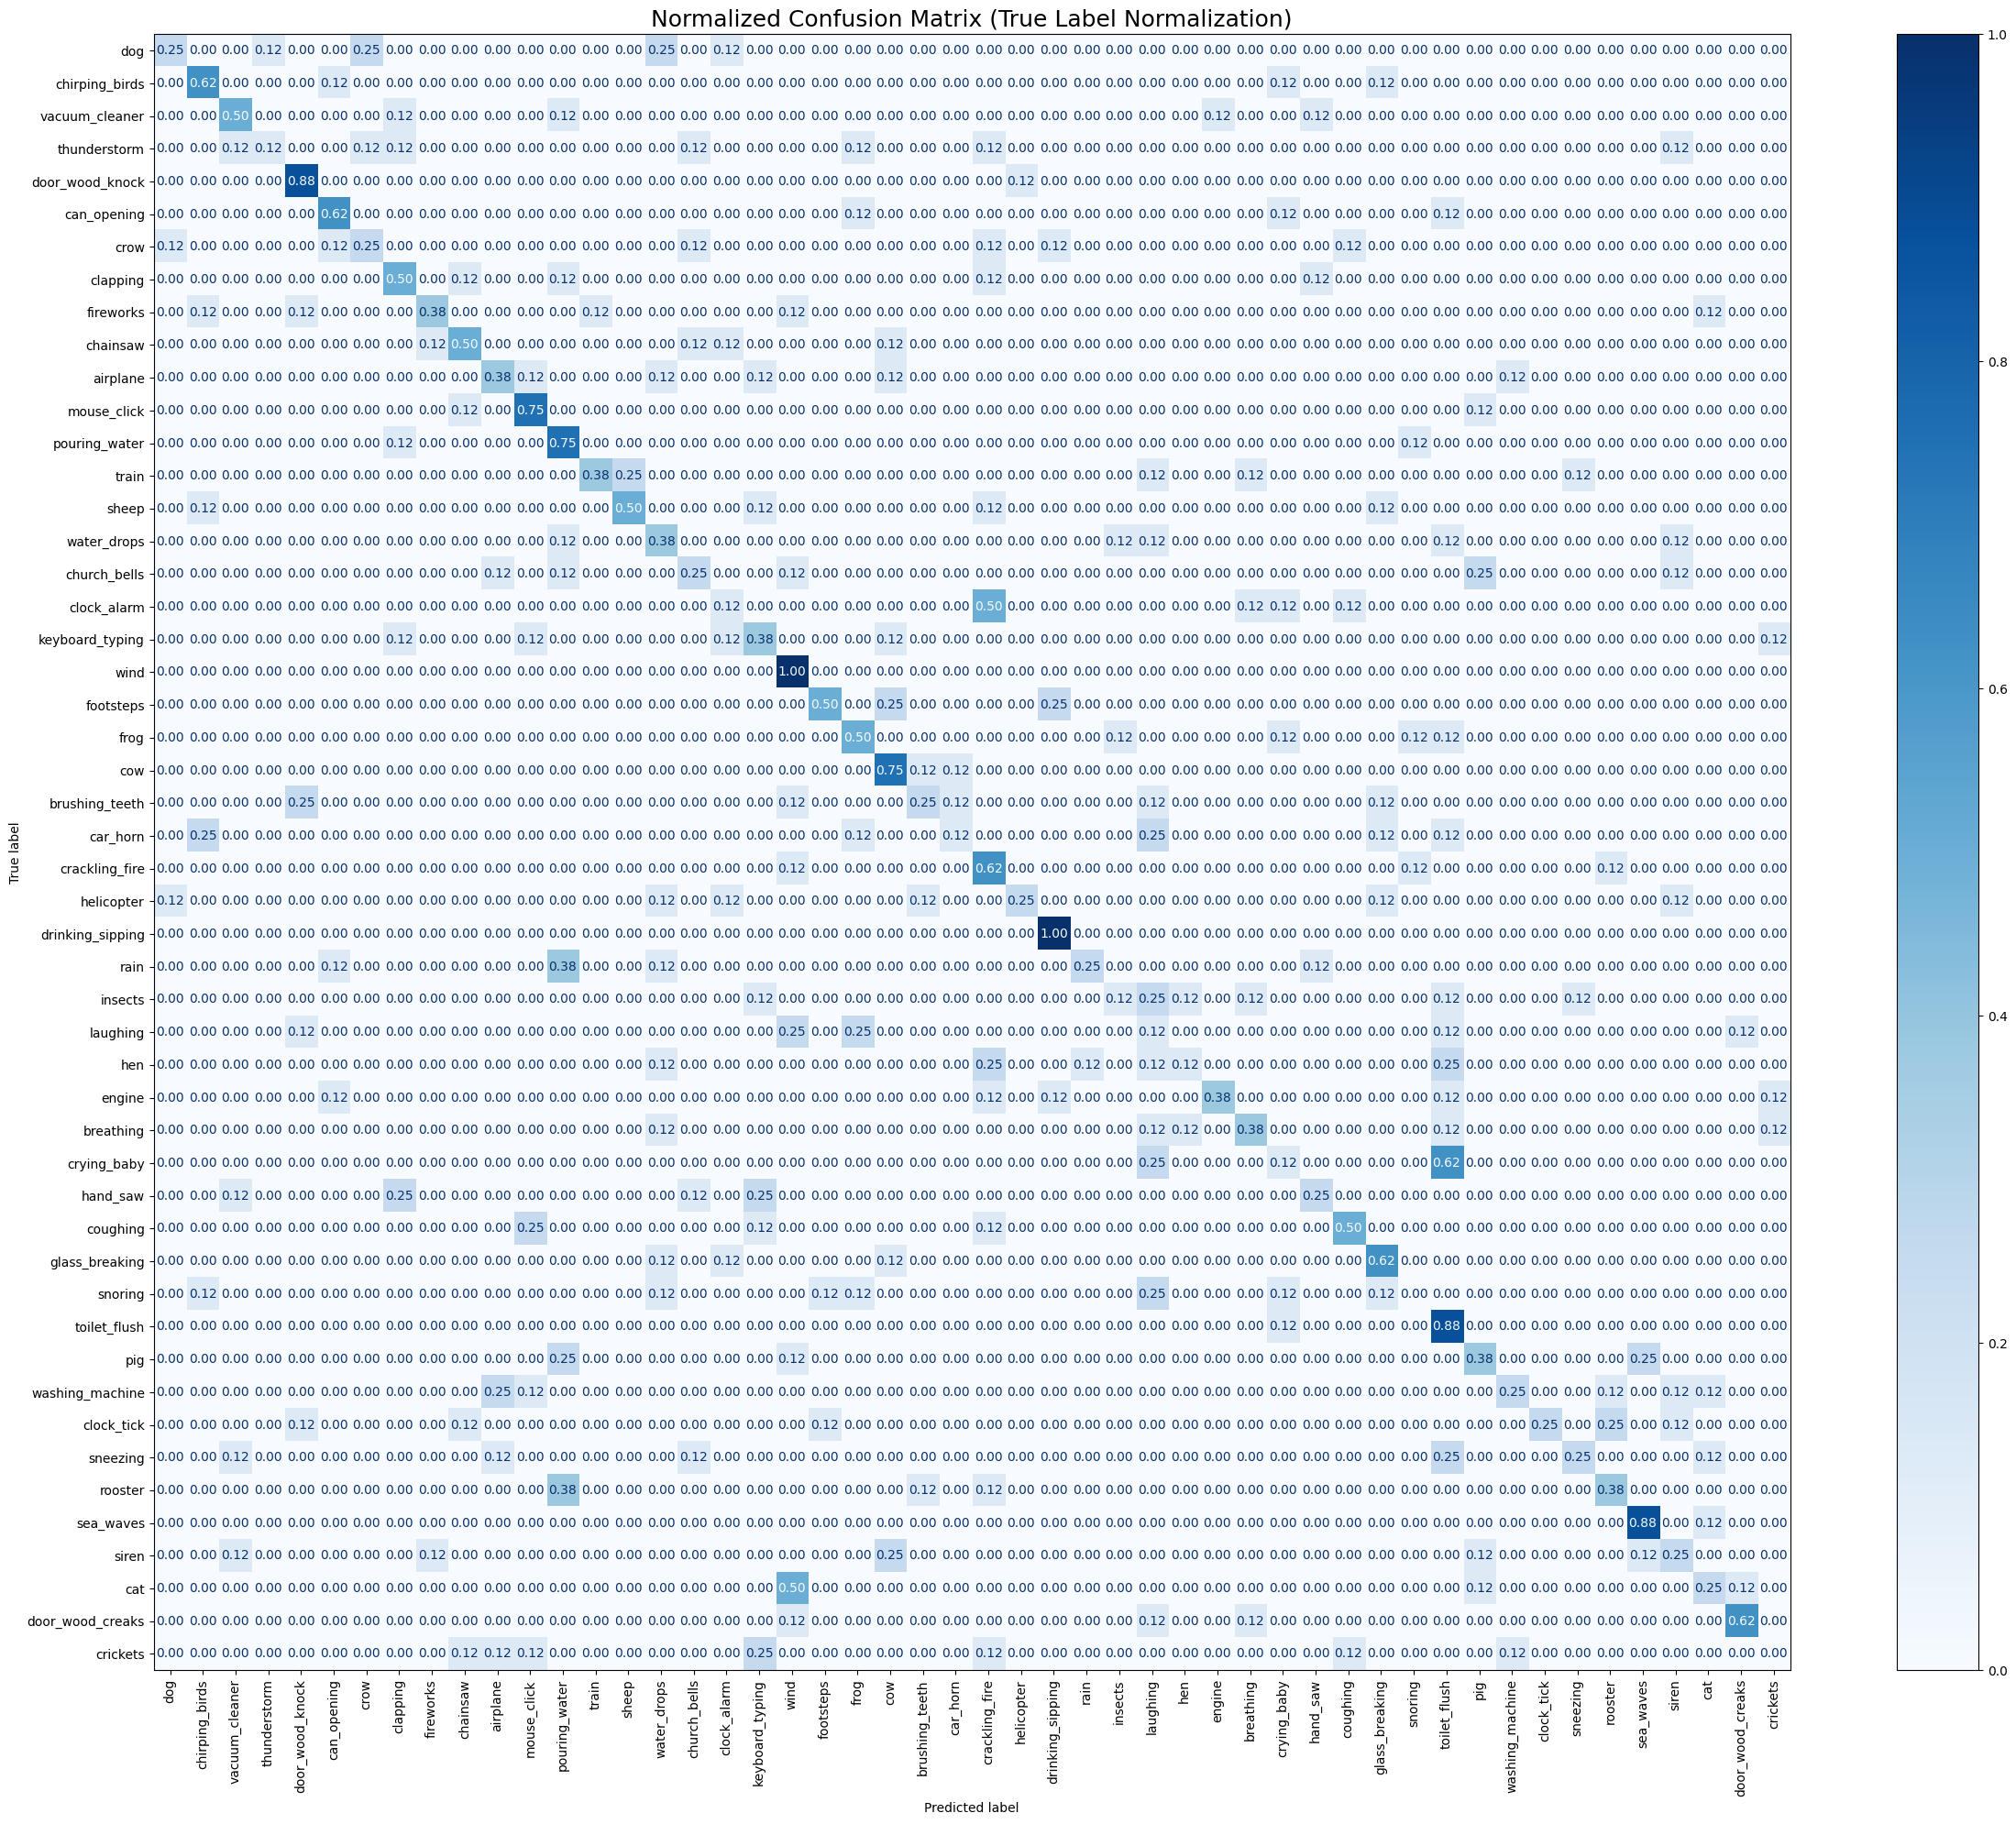

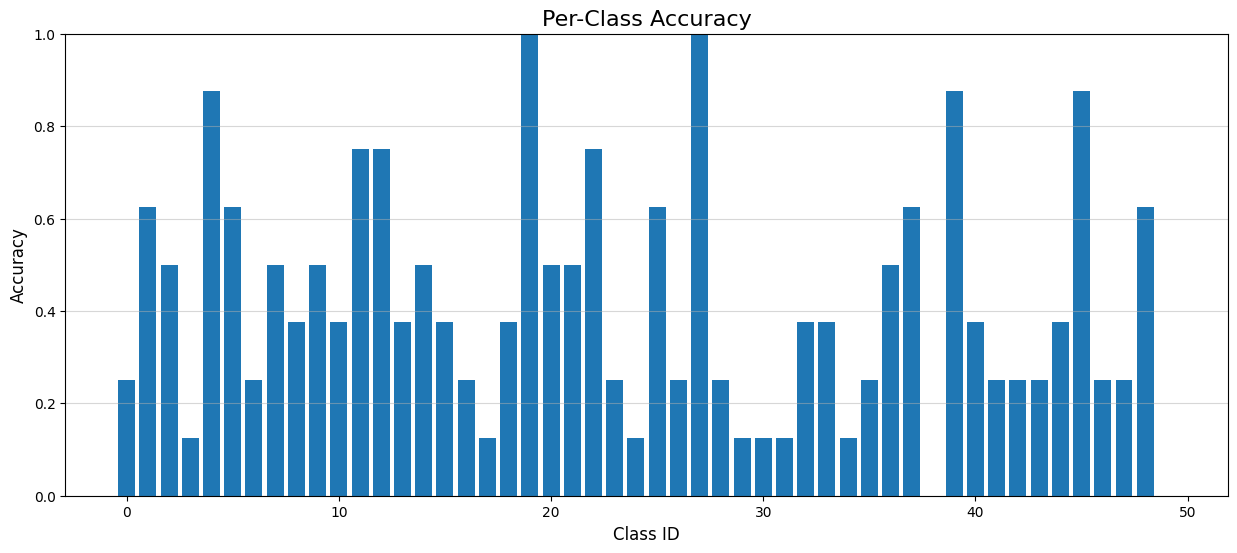

In [5]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get best model from hyperparameter tuning
best_knn = search.best_estimator_
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Visualize with class labels
fig, ax = plt.subplots(figsize=(25, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=valid_metadata['category'].unique())
disp.plot(ax=ax, cmap='Blues', values_format='.2f', xticks_rotation=90)
plt.title('Normalized Confusion Matrix (True Label Normalization)', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Additional diagnostics: Per-class accuracy
class_accuracy = cm.diagonal()
plt.figure(figsize=(15, 6))
plt.bar(range(len(class_accuracy)), class_accuracy)
plt.xlabel('Class ID', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=16)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.5)
plt.show()

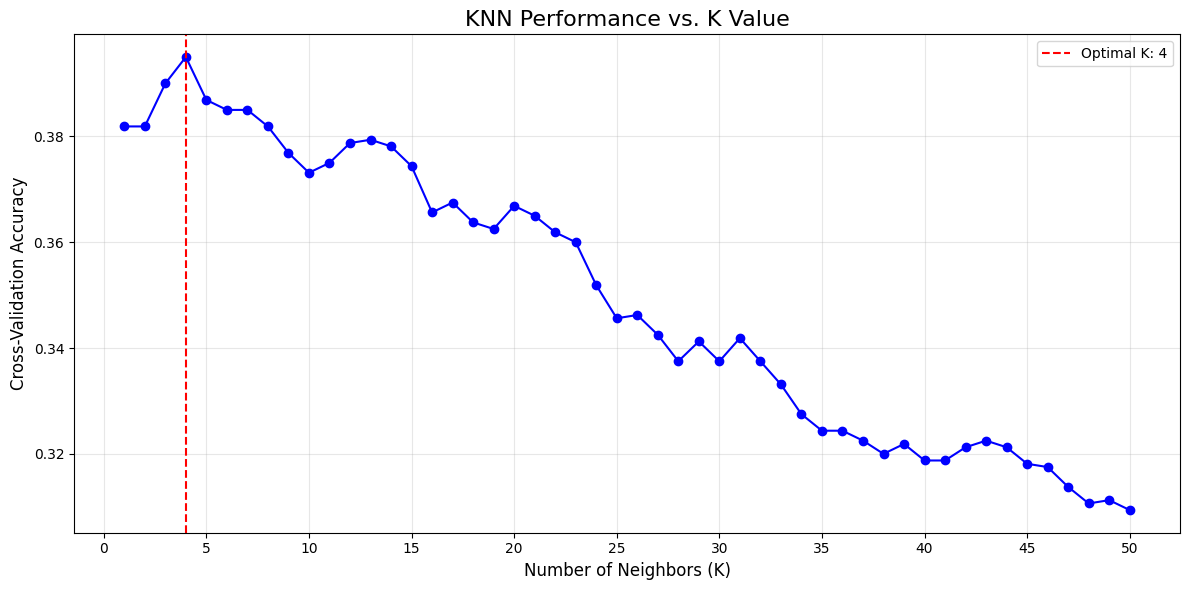

Optimal K value: 4 with accuracy: 0.3950


In [6]:
# Cel: Finding Best K
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Setup K range to test
k_range = range(1, 51)
k_scores = []

# Evaluate different K values
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, 
                              weights='distance', 
                              metric='cosine')
    scores = cross_val_score(knn, X_train, y_train, cv=3, n_jobs=-1)
    k_scores.append(scores.mean())

# Find optimal K
optimal_k = k_range[np.argmax(k_scores)]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(k_range, k_scores, marker='o', linestyle='-', color='b')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K: {optimal_k}')
plt.xlabel('Number of Neighbors (K)', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.title('KNN Performance vs. K Value', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(0, 51, 5))
plt.tight_layout()
plt.show()

print(f"Optimal K value: {optimal_k} with accuracy: {max(k_scores):.4f}")